**Introduction:**

Our project embarks on training a YOLOv8 model, the pinnacle of real-time object detection. YOLO, short for "You Only Look Once," revolutionized object detection by prioritizing speed and efficiency without compromising accuracy. YOLOv8 continues this legacy, striking a balance between speed and precision.

**Understanding YOLO Models:**

**Innovation in Object Detection:** YOLO's core principle is fast, single-shot object detection. It swiftly processes images, making it ideal for applications like autonomous vehicles and surveillance.

**YOLOv8: The Evolution:** We focus on YOLOv8, the latest YOLO iteration. It merges past advancements, offering a versatile solution for various domains.

**Custom Dataset Training:** We'll train YOLOv8 on a custom dataset, tailored to our objectives. This involves data collection, annotation, and model training.

**Project Goals:**
- Train YOLOv8 to detect "Drones" in an image.
- Evaluate the model's performance.
- Fine-tune for optimal results.

In this project, we explore YOLOv8's capabilities and leverage deep learning to create a customized, accurate, and efficient object detection solution.

"YOLOv8, the most recent addition to the YOLO family of real-time object detectors, combines state-of-the-art accuracy and speed. It builds upon the innovations from earlier YOLO versions, introducing novel features and optimizations that render it a top pick for a multitude of object detection tasks across diverse applications."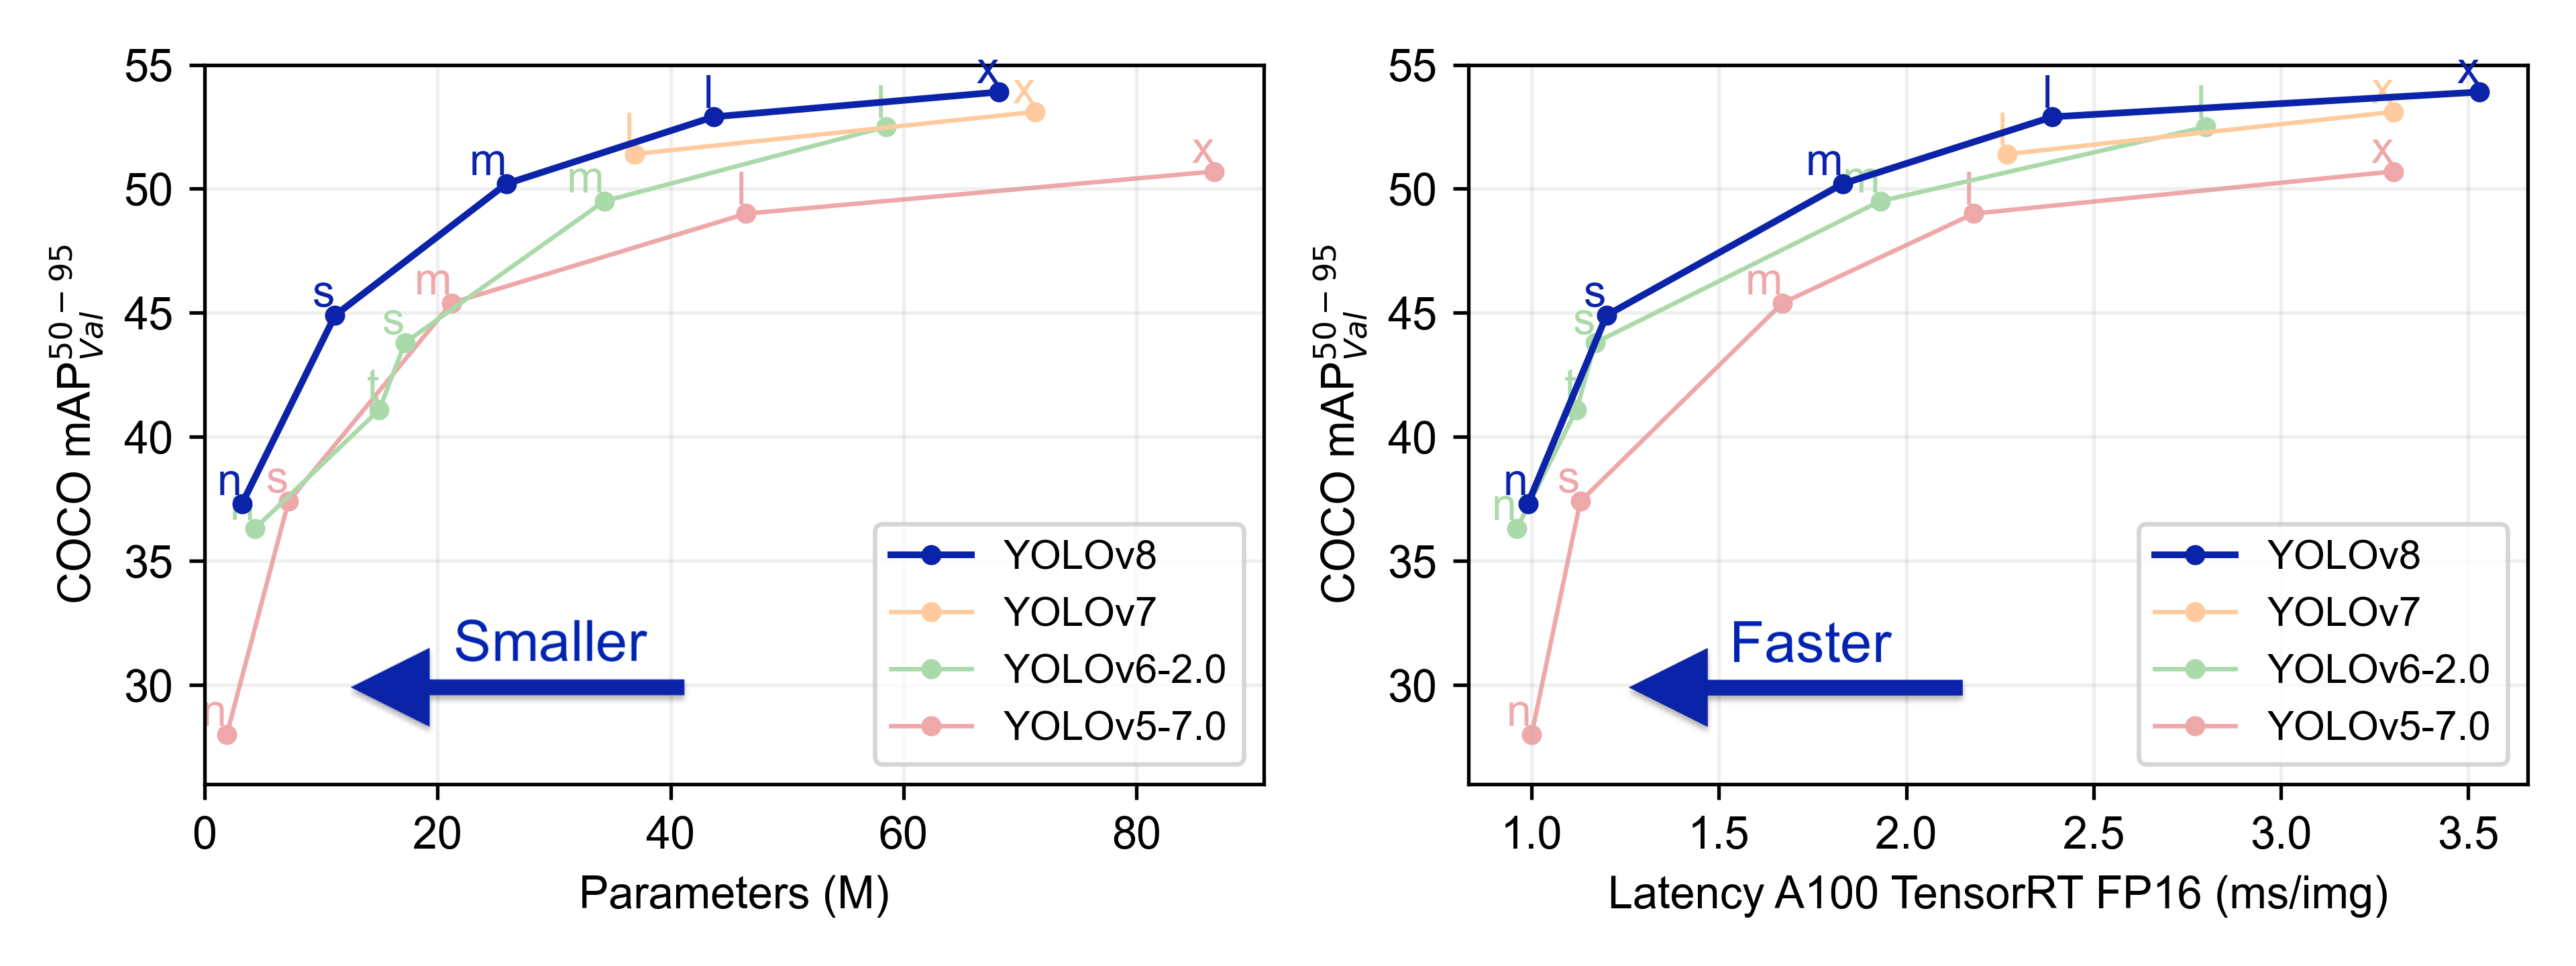

image source : [Ultralytics](https://docs.ultralytics.com/models/yolov8/#overview)

In [ ]:
# Importing required packages
!pip install ultralytics
import os
import shutil
from ultralytics import YOLO
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np


In the first step I will download a custom dataset from [Roboflow](https://universe.roboflow.com/mltrain/drone-detection-iwgzl/dataset/1#) in YOLOv8 format for our task which is "drone" detection.

In [2]:
# Downloading the dataset
!curl -L https://universe.roboflow.com/ds/!!!!!!!!!!! > /content/roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   2577      0 --:--:-- --:--:-- --:--:--  2576
100 49.3M  100 49.3M    0     0  49.8M      0 --:--:-- --:--:-- --:--:-- 49.8M


In [3]:
# Creating a directory for our images dataset
!mkdir images

In [ ]:
# Unzipping the downloaded file
!unzip /content/roboflow.zip -d /content/images

In [5]:
# Checking the content of our image directory
os.listdir('/content/images')

['README.roboflow.txt',
 'train',
 'README.dataset.txt',
 'data.yaml',
 'test',
 'valid']

Now I'll show 5 random images from our training set next to labeled images with bounding boxes.
The YOLOv8 format typically has bounding box coordinates normalized relative to the width and height of the image, in the format [class, x_center, y_center, width, height]. We need to convert these normalized values to actual pixel coordinates for drawing.

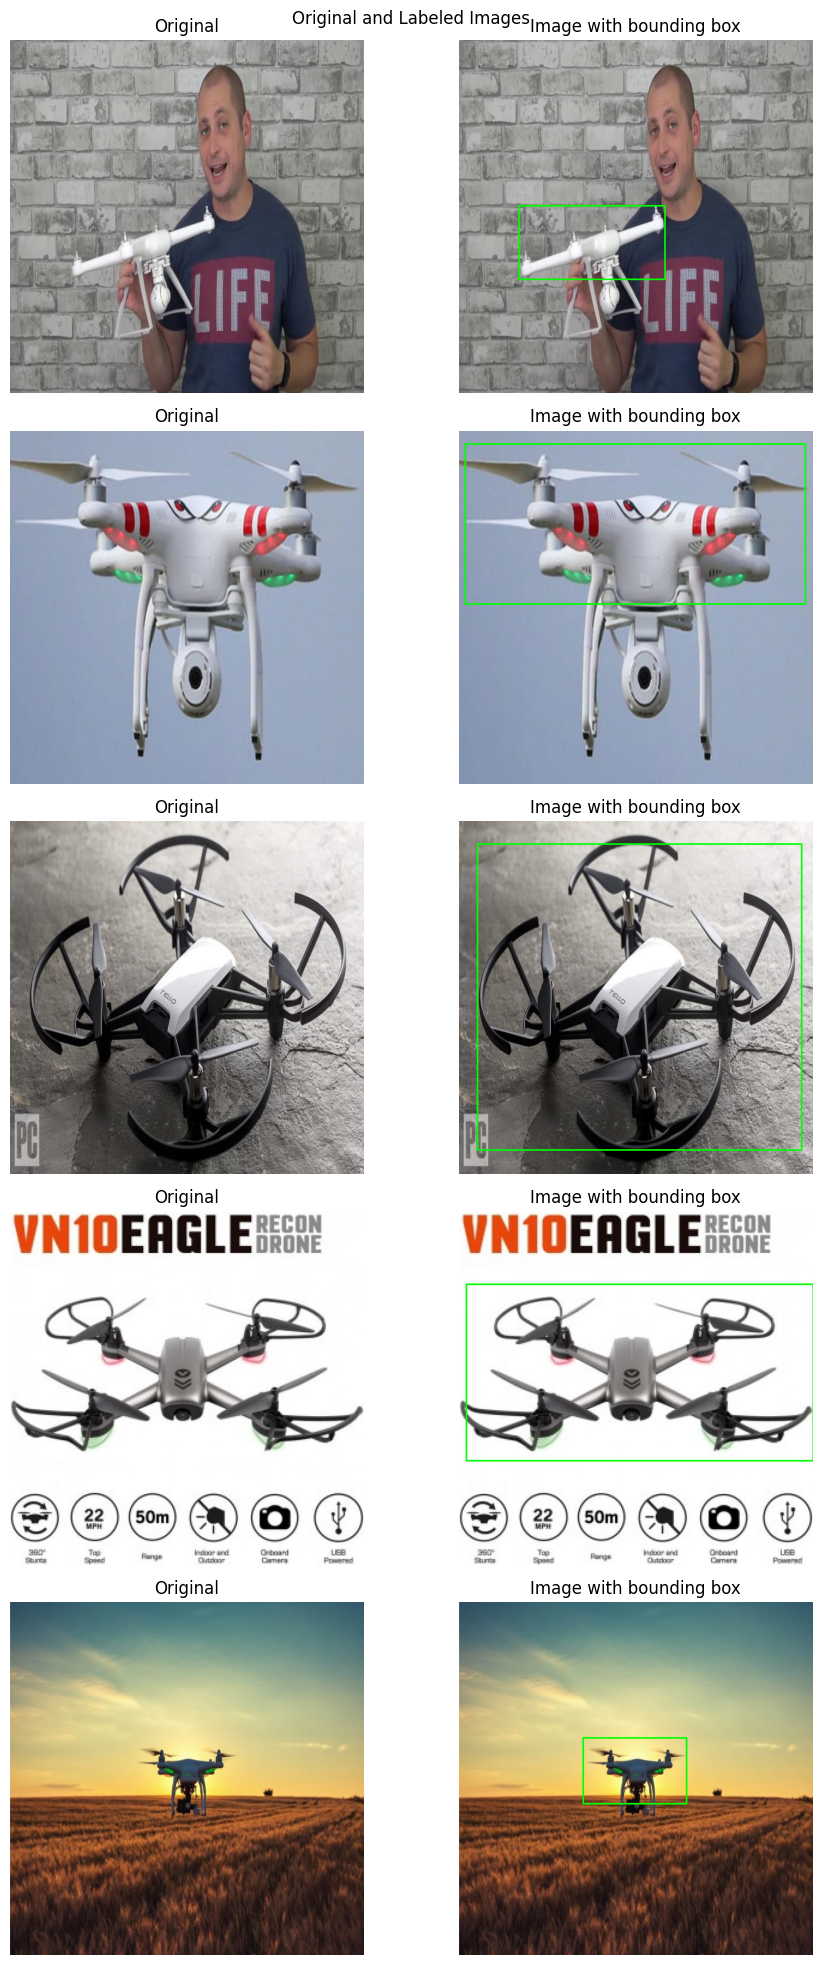

In [6]:
# Set the paths to the directories
image_dir = '/content/images/train/images'
bbox_dir = '/content/images/train/labels'

# Function to read and convert bounding box coordinates from a file
def read_bboxes(file_path, img_shape):
    with open(file_path, 'r') as file:
        bboxes = []
        for line in file:
            # YOLO format: class, x_center, y_center, width, height (normalized)
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x_center, y_center, width, height = x_center * img_shape[1], y_center * img_shape[0], width * img_shape[1], height * img_shape[0]
            x, y = int(x_center - width / 2), int(y_center - height / 2)
            bboxes.append([int(x), int(y), int(width), int(height)])
    return bboxes

# Function to draw bounding boxes on an image
def draw_bboxes(image, bboxes):
    for bbox in bboxes:
        x, y, w, h = bbox
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image

# Get a list of image file names
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
random.shuffle(image_files)

# Select 5 random images
selected_images = image_files[:5]

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
fig.suptitle('Original and Labeled Images')

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(image_dir, img_file)
    bbox_path = os.path.join(bbox_dir, os.path.splitext(img_file)[0] + '.txt')

    # Read image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
    img_shape = image.shape

    # Read and draw bounding boxes
    bboxes = read_bboxes(bbox_path, img_shape)
    image_with_bboxes = draw_bboxes(image.copy(), bboxes)

    # Show original and labeled images
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    axes[i, 1].imshow(image_with_bboxes)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Image with bounding box')

plt.tight_layout()
plt.show()


In [7]:
# Configuring the data.yaml file for this project and editing related directories
import yaml
config = {'path': '/content/images',
         'train': '/content/images/train',
         'val': '/content/images/valid',
         'nc': 1,
         'names': ['Drone']}

with open("data.yaml", "w") as file:
    yaml.dump(config, file, default_flow_style=False)

Loading the model

In [8]:
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 204MB/s]


We will now train the model on the custom dataset for 20 epochs.Actually we will start with the pre-trained weights and fine tune them for our purpose.

**Tip : make sure you're using a GPU for training:**

In [9]:
# If you are using a GPU you'd get a result like below otherwise something like this may appear :
#/bin/bash: line 1: nvidia-smi: command not found

!nvidia-smi

Wed Dec 20 19:38:43 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
# Here just make sure to pass the path of configured data.yaml file for your project!!!!
result = model.train(data='/content/data.yaml',epochs=20)

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/data.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=tor

100%|██████████| 755k/755k [00:00<00:00, 14.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 59.4MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/images/train/labels... 1019 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1019/1019 [00:00<00:00, 1341.88it/s]

train: New cache created: /content/images/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/images/valid/labels... 293 images, 0 backgrounds, 0 corrupt: 100%|██████████| 293/293 [00:00<00:00, 416.35it/s]


val: New cache created: /content/images/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.06G      1.552      1.914      1.845         24        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

                   all        293        323      0.016      0.161     0.0059    0.00145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.26G      1.811      1.946      2.048         28        640: 100%|██████████| 64/64 [00:34<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


                   all        293        323     0.0103      0.393    0.00691    0.00171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.29G      1.801      1.912      2.055         30        640: 100%|██████████| 64/64 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


                   all        293        323     0.0201      0.511     0.0148    0.00432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.28G       1.73      1.858       2.02         26        640: 100%|██████████| 64/64 [00:33<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        293        323      0.369      0.474      0.339      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.34G      1.688      1.798      1.988         25        640: 100%|██████████| 64/64 [00:33<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

                   all        293        323      0.477      0.412      0.382      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.28G      1.633       1.73      1.904         24        640: 100%|██████████| 64/64 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

                   all        293        323      0.644       0.69      0.674      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       7.3G      1.597      1.615      1.873         18        640: 100%|██████████| 64/64 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

                   all        293        323      0.129      0.402      0.108     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.29G      1.543      1.579      1.831         24        640: 100%|██████████| 64/64 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

                   all        293        323      0.726       0.63      0.671      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.29G       1.53      1.489      1.807         19        640: 100%|██████████| 64/64 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        293        323      0.776      0.666      0.744       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.28G      1.504      1.455      1.792         29        640: 100%|██████████| 64/64 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

                   all        293        323      0.789      0.684      0.776      0.365


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.26G      1.473      1.246      1.932         11        640: 100%|██████████| 64/64 [00:34<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

                   all        293        323      0.752      0.759        0.8      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.29G       1.41      1.177       1.86         12        640: 100%|██████████| 64/64 [00:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]

                   all        293        323      0.737       0.73      0.776      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.29G      1.384      1.113      1.843         11        640: 100%|██████████| 64/64 [00:34<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        293        323      0.789      0.768      0.823      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       7.3G      1.299       1.04      1.728         11        640: 100%|██████████| 64/64 [00:33<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        293        323      0.784      0.783      0.822      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.29G      1.297     0.9686       1.74         13        640: 100%|██████████| 64/64 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

                   all        293        323       0.85       0.84      0.888      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.29G      1.231      0.939      1.662         13        640: 100%|██████████| 64/64 [00:33<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

                   all        293        323      0.895      0.854      0.919      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.28G        1.2     0.8922      1.662         11        640: 100%|██████████| 64/64 [00:33<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        293        323      0.883      0.772      0.887      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       7.3G      1.169     0.8488      1.632         11        640: 100%|██████████| 64/64 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]

                   all        293        323      0.931      0.873       0.94      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.29G      1.135     0.7951        1.6         11        640: 100%|██████████| 64/64 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]

                   all        293        323      0.894      0.885       0.94      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       7.3G      1.115     0.7629      1.574         11        640: 100%|██████████| 64/64 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


                   all        293        323      0.901        0.9       0.94      0.588

20 epochs completed in 0.254 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


                   all        293        323      0.901      0.898       0.94      0.587
Speed: 0.4ms preprocess, 13.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train


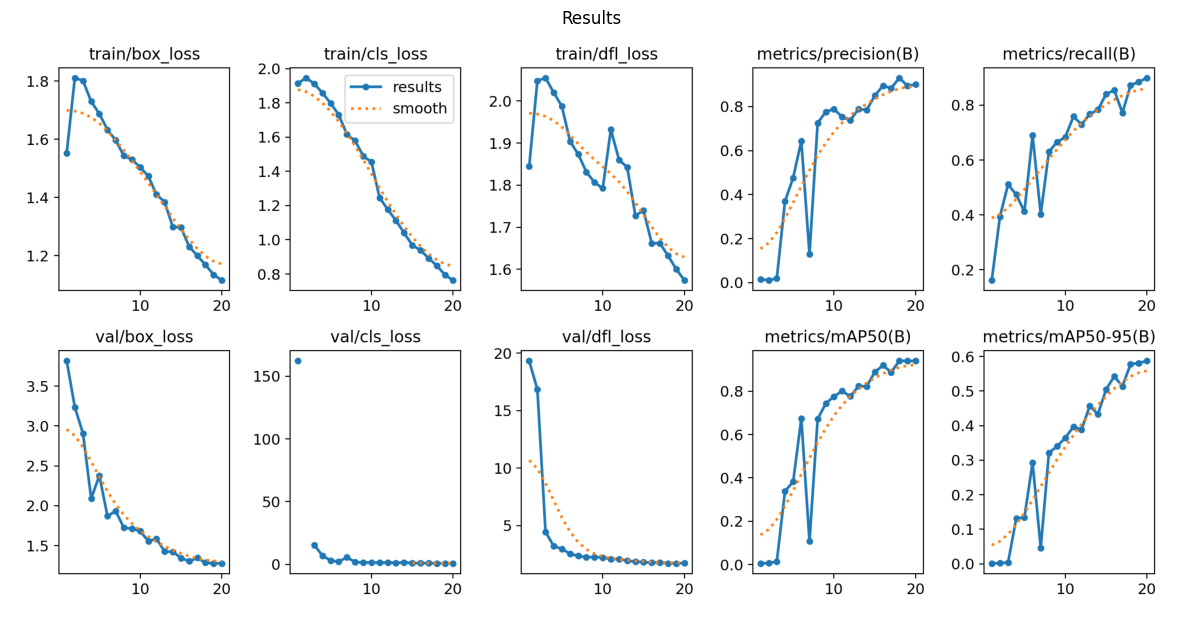

In [22]:
result_curves = cv2.cvtColor(cv2.imread('/content/runs/detect/train/results.png'),cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,10))
plt.title('Results')
plt.axis('off')
plt.imshow(result_curves)

## **Predicting with Our model**

In [ ]:
results = model("/content/images/test/images", save=True)

Now we show some random images form test set with ground truth bounding boxes drawn on it and also the model prediction next to it.

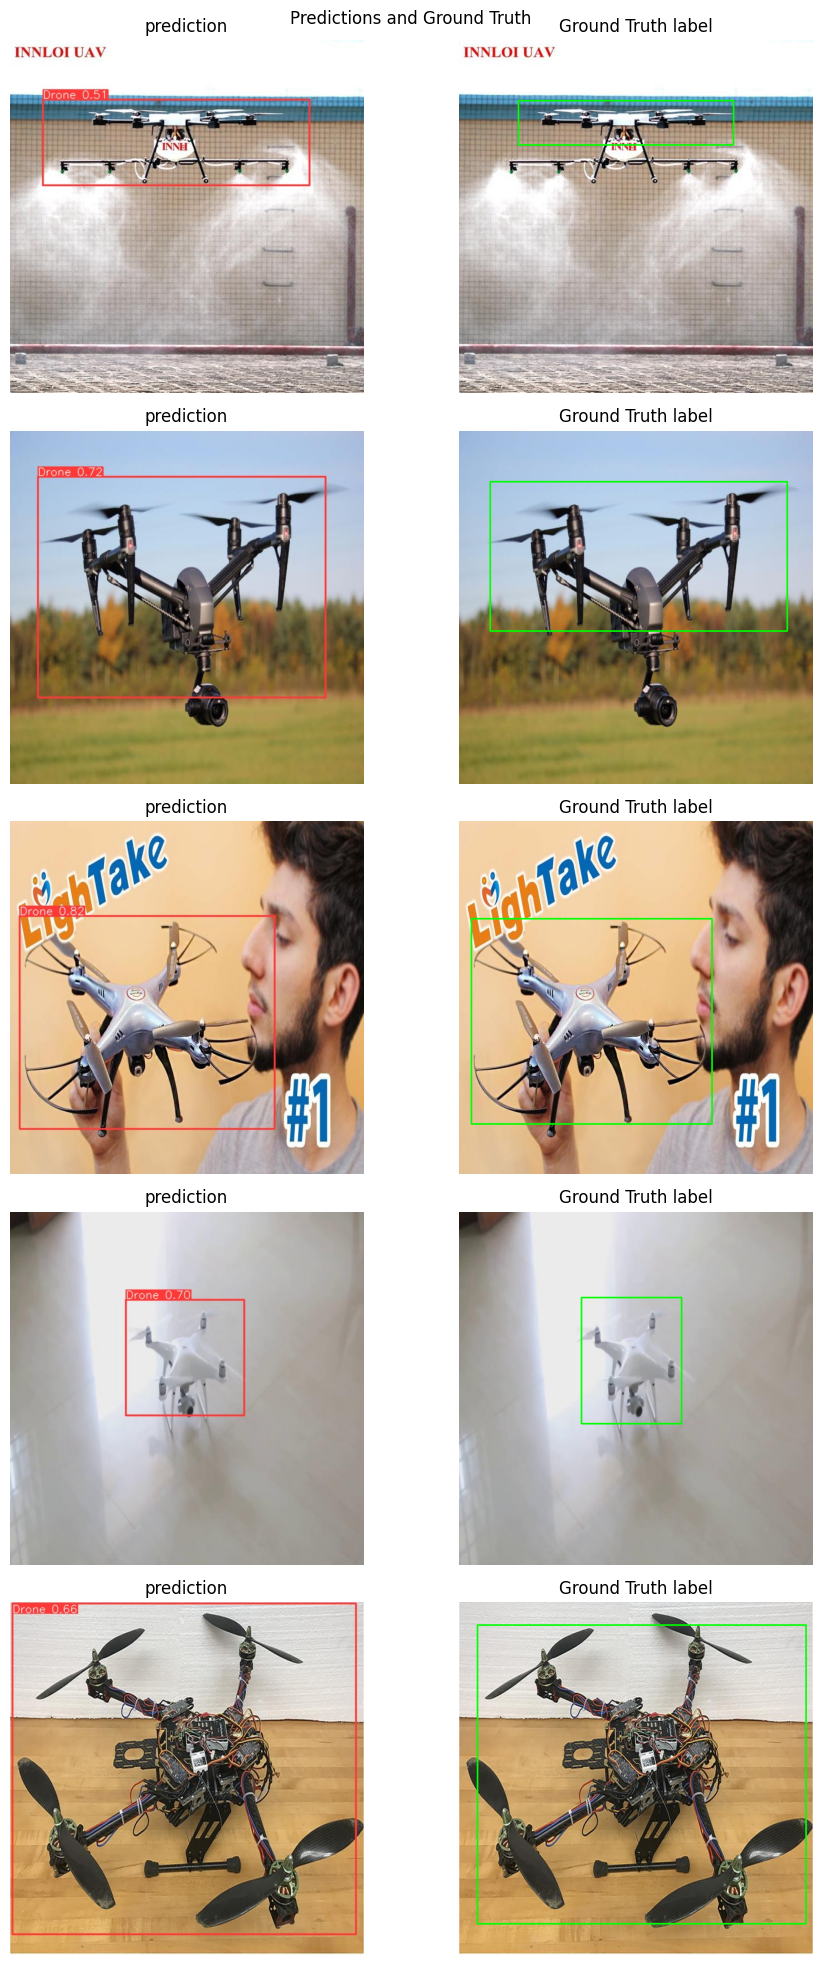

In [20]:
# Set the paths to the directories
image_dir = '/content/images/test/images'
bbox_dir = '/content/images/test/labels'

# Function to read and convert bounding box coordinates from a file
def read_bboxes(file_path, img_shape):
    with open(file_path, 'r') as file:
        bboxes = []
        for line in file:
            # YOLO format: class, x_center, y_center, width, height (normalized)
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x_center, y_center, width, height = x_center * img_shape[1], y_center * img_shape[0], width * img_shape[1], height * img_shape[0]
            x, y = int(x_center - width / 2), int(y_center - height / 2)
            bboxes.append([int(x), int(y), int(width), int(height)])
    return bboxes

# Function to draw bounding boxes on an image
def draw_bboxes(image, bboxes):
    for bbox in bboxes:
        x, y, w, h = bbox
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image

# Get a list of image file names
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
random.shuffle(image_files)

# Select 5 random images
selected_images = image_files[:5]

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
fig.suptitle('Predictions and Ground Truth')

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(image_dir, img_file)
    bbox_path = os.path.join(bbox_dir, os.path.splitext(img_file)[0] + '.txt')

    # Read image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB
    img_shape = image.shape

    # Read and draw bounding boxes
    bboxes = read_bboxes(bbox_path, img_shape)
    image_with_bboxes = draw_bboxes(image.copy(), bboxes)
    prediction = cv2.cvtColor(cv2.imread('/content/runs/detect/preds/'+img_file), cv2.COLOR_BGR2RGB)
    # Show original and labeled images
    axes[i, 0].imshow(prediction)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('prediction')

    axes[i, 1].imshow(image_with_bboxes)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Ground Truth label')

plt.tight_layout()
plt.show()
